# SpikeInterface DEMO v0.95 -  DCBT school Nijmegen - Sep 2022


In this demo, you will use SpikeInterface to analyze a 64-channel dataset from am "ASSY-156-P1" probe from Cambridge Neurotech. 
The dataset is kindly provided by [Samuel McKenzie's Lab](https://mckenzieneurolab.com/). 

The objective of this demo is to show all the functionalities of SpikeInterface on a real-world example.

# Table of contents

* [0. Preparation](#preparation)
* [1. Loading the data and probe information](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Data compression](#compression)
* [5. Spike sorting](#spike-sorting)
* [6. Extracting waveforms](#waveforms)
* [7. Postprocessing](#postprocessing)
* [8. Viewers](#viewers)
* [9. Validation and curation](#curation)
* [10. Spike sorting comparison](#comparison)
* [11. Exporters](#exporters)
* [12. Saving to NWB](#nwb)

# 0. Preparation <a class="anchor" id="preparation"></a>

### Download the ephys data

First, we need to download the recording. Feel free to use your own recordings as well later on. 

The dataset is called `cambridge_data.dat` and can be found on this [drive link](https://drive.google.com/drive/folders/1eWPuOd8q4MjpVpwazkWygQJDzJnToN3i) (`practice_2_real_dataset` folder). Move the dataset in the current folder.
The recording was performed with the "ASSY-156-P1" probe with 4 shanks of 16 channels (in total 64 channels).


### Import the modules

Let's now import the `spikeinterface` modules that we need:

In [1]:
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.widgets as sw

In [2]:
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.96.0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import spikeinterface_gui as sigui

import warnings
warnings.simplefilter("ignore")

%matplotlib widget

# 1. Loading recording and probe information <a class="anchor" id="loading"></a>

In [6]:
# file path
base_folder = Path('.')
recording_file = base_folder / 'data.bin'

# parameters to load the bin/dat format
num_channels = 64
sampling_frequency = 30000
gain_to_uV = 0.195
offset_to_uV = 0
dtype = "int16"
time_axis = 1

In [7]:
recording = si.read_binary(recording_file, num_chan=num_channels, sampling_frequency=sampling_frequency,
                           dtype=dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
                           time_axis=time_axis)

The `read_binary()` function returns a `RecordingExtractor` object. We can print it to visualize some of its properties:

In [8]:
recording

BinaryRecordingExtractor: 64 channels - 1 segments - 30.0kHz - 16.000s
  file_paths: ['C:\\Users\\rodri\\Documents\\Bonsai-RN\\spikeinterface\\spiketutorials\\Official_Tutorial_SI_0.95_Sep2022\\data.bin']

We can further `annotate` the recording to tell SI that it is not filtered yet. This will prevent further mistakes in the pipieline, such as attempting to extract waveforms from unfiltered data.

In [9]:
recording.annotate(is_filtered=False)

While the `read_binary()` function is part of the `core` module (as it's used internally by SI to store data in a convenient format), the `extractor` module allows you to load many file formats used in electrophysiology. 

The extractors available in SI are all loaded using the [NEO](https://neo.readthedocs.io/en/stable/) python package.

We can access the full list of available extractors with:

In [10]:
se.recording_extractor_full_dict

{'binary': spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor,
 'numpy': spikeinterface.core.numpyextractors.NumpyRecording,
 'shybrid': spikeinterface.extractors.shybridextractors.SHYBRIDRecordingExtractor,
 'mda': spikeinterface.extractors.mdaextractors.MdaRecordingExtractor,
 'nwb': spikeinterface.extractors.nwbextractors.NwbRecordingExtractor,
 'cbin_ibl': spikeinterface.extractors.cbin_ibl.CompressedBinaryIblExtractor,
 'mcsh5': spikeinterface.extractors.mcsh5extractors.MCSH5RecordingExtractor,
 'alphaomega': spikeinterface.extractors.neoextractors.alphaomega.AlphaOmegaRecordingExtractor,
 'axona': spikeinterface.extractors.neoextractors.axona.AxonaRecordingExtractor,
 'biocam': spikeinterface.extractors.neoextractors.biocam.BiocamRecordingExtractor,
 'blackrock': spikeinterface.extractors.neoextractors.blackrock.BlackrockRecordingExtractor,
 'ced': spikeinterface.extractors.neoextractors.ced.CedRecordingExtractor,
 'edf': spikeinterface.extractors.neoextractors

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `BinaryRecordingExtractor` is designed specifically for raw binary files datasets (.bin, .dat, .raw).

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [11]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_segments = recording.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")

Channel ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Sampling frequency: 30000
Number of channels: 64
Number of segments: 1


SpikeInterface supports multi-segment recordings. A segment is a contiguous piece of data, and sometimes recordings can be made of multiple acquisitions, for examples a baseline, a stimulation phase, and a post recording. In such cases, the recording object will be made of multiple segments and be treated as such over the pipeline.

The `get_traces()` function returns a TxN numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [12]:
trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [13]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (60000, 64)


Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://gin.g-node.org/spikeinterface/probeinterface_library/) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [14]:
import probeinterface as pi
from probeinterface.plotting import plot_probe

In [15]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-156-P-1'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

cambridgeneurotech - ASSY-156-P-1 - 64ch - 4shanks


In most experiments, the neural probe has a connector, that is interfaced to an headstage, which in turn connects to the acquisition system. This *pathway* usually results in a channel remapping, which means that the order of the contacts on the probe is different than the order of the recorded traces.

`probeinterface` provides a growing collection of common pathways that can be loaded directly to wire a device and apply the correct channel mapping:

In [16]:
pi.get_available_pathways()

['H32>RHD2132',
 'ASSY-156>RHD2164',
 'ASSY-116>RHD2132',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>RHD2164',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>two_RHD2132',
 'cambridgeneurotech_mini-amp-64']

In [17]:
probe.wiring_to_device('ASSY-156>RHD2164')

(<matplotlib.collections.PolyCollection at 0x244964b7f40>,
 <matplotlib.collections.PolyCollection at 0x2449648f640>)

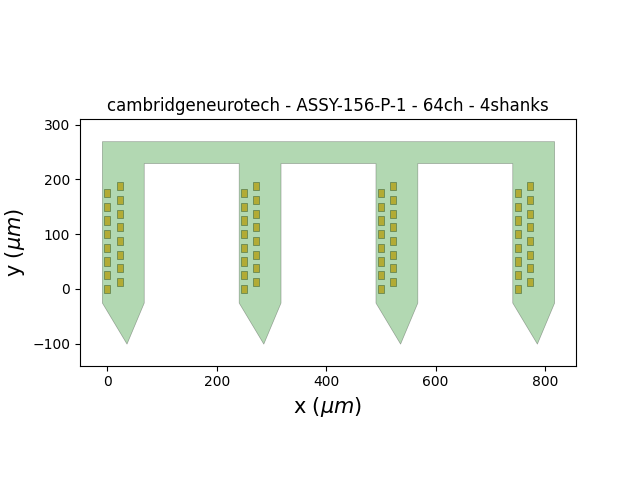

In [18]:
fig, ax = plt.subplots()
plot_probe(probe, ax=ax)

(-50.0, 300.0)

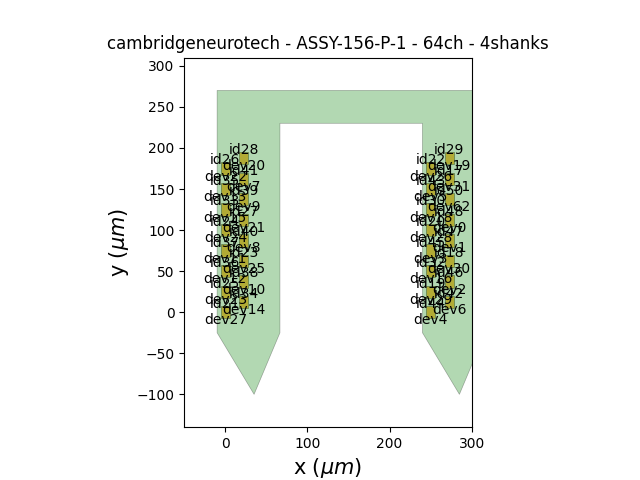

In [19]:
fig, ax = plt.subplots()
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)
ax.set_xlim(-50, 300)

The probe now has contact ids `id#` and device ids `dev#`! We can also visualize the probe information as a `pandas` dataframe:

In [20]:
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,1,2,47
1,2,2,46
2,3,2,45
3,4,2,44
4,5,3,43
...,...,...,...
59,60,3,52
60,61,3,51
61,62,3,50
62,63,3,49


Note that also the `shank_id` is loaded with the probe.

A `probeinterface` object can be loaded directly to a SI recording object:

In [21]:
recording_prb = recording.set_probe(probe, group_mode="by_shank")

When loading the probe, the device indices (and all the other contact properties) are automatically sorted:

In [22]:
probe_rec = recording_prb.get_probe()
probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,48,1,0
1,47,1,1
2,46,1,2
3,45,1,3
4,44,1,4
...,...,...,...
59,53,2,59
60,52,2,60
61,51,2,61
62,50,1,62


In [23]:
print(f'Channels after loading the probe file: \n{recording_prb.get_channel_ids()}')
print(f'Channel groups after loading the probe file: \n{recording_prb.get_channel_groups()}')

Channels after loading the probe file: 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Channel groups after loading the probe file: 
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 2 1 1 0 0 0 0 0 0 1 0 1 1 1 1 2 2 2 2 2
 3 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 3 3 3 2 3 2 2 2 2 1 2]


The `widgets` module includes several convenient plotting functions that can be used to explore the data:

In [27]:
w_ts = sw.plot_timeseries(recording_prb, order_channel_by_depth=True, backend="ipywidgets",
                          clim=(-1, 1000))

AppLayout(children=(VBox(children=(FloatSlider(value=0.0, continuous_update=False, description='time:', layout…

### Properties 

`RecordingExtractor` object can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `SortingExtractor` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [28]:
print("Properties before loading the probe:", list(recording.get_property_keys()))

Properties before loading the probe: ['gain_to_uV', 'offset_to_uV']


In [29]:
print("Properties after loading the probe:", list(recording_prb.get_property_keys()))

Properties after loading the probe: ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group']


After loading the probe we now have some new properties: `contact_vector`, `location`, and `group`.

Let's add some new properties! 
The first 32 channels are in the CA1 area, the second 32 are in the CA3 area:

In [30]:
brain_area_property_values = ['CA1']*32 + ['CA3']*32
print(brain_area_property_values)

['CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3']


In [31]:
recording_prb.set_property(key='brain_area', values=brain_area_property_values)

We can also specify a property on a subset of channels. In this case, the non-specified channels will be filled empty values:

In [32]:
recording_prb.set_property(key='quality', values=["good"]*(recording_prb.get_num_channels() - 3),
                           ids=recording_prb.get_channel_ids()[:-3])

In [33]:
recording_prb.get_property("quality")

array(['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', '', '', ''], dtype='<U4')

In [34]:
print("Properties after adding custom properties:", list(recording_prb.get_property_keys()))

Properties after adding custom properties: ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'brain_area', 'quality']


**NOTE:** Internally the properties is jus a dictionary attached to the recording that is accessible as `_properties`

In [35]:
print(recording_prb._properties.keys())

dict_keys(['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'brain_area', 'quality'])


### Annotations

*Annotations* can be attached to any object and they can carry any information related to the recording or sorting objects.

Let's add an annotation about this tutorial:

In [36]:
recording_prb.annotate(description="Dataset for SI 0.93 tutorial")

In [37]:
print(recording_prb.get_annotation_keys())

['is_filtered', 'probe_0_planar_contour', 'description']


# 2. Preprocessing <a class="anchor" id="preprocessing"></a>


Now that the probe information is loaded we can do some preprocessing using `preprocessing` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

We will focus only on the first shank (grouo `0`) for the following analysis:

In [38]:
recordings_by_group = recording_prb.split_by("group")
print(recordings_by_group)

{0: ChannelSliceRecording: 16 channels - 1 segments - 30.0kHz - 16.000s, 1: ChannelSliceRecording: 16 channels - 1 segments - 30.0kHz - 16.000s, 2: ChannelSliceRecording: 16 channels - 1 segments - 30.0kHz - 16.000s, 3: ChannelSliceRecording: 16 channels - 1 segments - 30.0kHz - 16.000s}


In [39]:
recording_to_process = recordings_by_group[0]

In [40]:
recording_to_process.get_num_channels()

16

Below, we bandpass filter the recording and apply common median reference to the original recording:

In [41]:
recording_f = spre.bandpass_filter(recording_to_process, freq_min=300, freq_max=6000)

We can see that the after filtering we can observe spiking activity on many channels! We can also apply other preprocessing steps to further increase the quality of the recording. 

For examplem let's apply Common Median Reference (CMR)

In [42]:
recording_cmr = spre.common_reference(recording_f, reference='global', operator='median')

We can plot the traces after applying CMR:

In [43]:
w = sw.plot_timeseries({"raw": recording_to_process, "filt": recording_f, "common": recording_cmr},
                        clim=(-1000, 1000), order_channel_by_depth=True,
                        backend="ipywidgets")

AppLayout(children=(VBox(children=(FloatSlider(value=0.0, continuous_update=False, description='time:', layout…

## Take only 5 min. for demo

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [48]:
fs = recording_cmr.get_sampling_frequency()
recording_sub = recording_cmr.frame_slice(start_frame=0*fs, end_frame=10*fs)
recording_sub

FrameSliceRecording: 16 channels - 1 segments - 30.0kHz - 10.000s

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

In [49]:
job_kwargs = dict(n_jobs=4, chunk_duration="1s", progress_bar=True)

In [50]:
if (base_folder / "preprocessed").is_dir():
    recording_saved = si.load_extractor(base_folder / "preprocessed")
else:
    recording_saved = recording_sub.save(folder=base_folder / "preprocessed", **job_kwargs)

write_binary_recording with n_jobs = 4 and chunk_size = 30000


write_binary_recording:   0%|          | 0/10 [00:00<?, ?it/s]

If we inspect the `preprocessed` folder, we find that a few files have been saved. Let's take a look at what they are:

In [54]:
recording_saved

BinaryFolderRecording: 16 channels - 1 segments - 30.0kHz - 10.000s

In [58]:
!ls {base_folder}/preprocessed

 Volume in drive C is Windows
 Volume Serial Number is 12D8-CF75

 Directory of C:\Users\rodri\Documents\Bonsai-RN\spikeinterface\spiketutorials\Official_Tutorial_SI_0.95_Sep2022

10/23/2022  02:37 PM    <DIR>          .
10/23/2022  02:37 PM    <DIR>          ..
10/23/2022  01:59 PM    <DIR>          .ipynb_checkpoints
07/07/2022  02:48 PM        61,440,000 data.bin
10/23/2022  01:37 PM               607 environment.yml
10/23/2022  02:31 PM    <DIR>          preprocessed
10/23/2022  01:37 PM             1,772 README.md
10/23/2022  01:37 PM               152 requirements.txt
10/23/2022  02:37 PM           301,260 SpikeInterface_Tutorial.ipynb
               5 File(s)     61,743,791 bytes
               4 Dir(s)  1,290,619,465,728 bytes free


The `traces_cached_seg0.raw` contains the processed raw data, while the `.json` files include information on how to reload the binary file. The `provenance.json` includes the information of the recording before saving it to a binary file, and the `probe.json` represents the probe object. 

The `save` returns a new *cached* recording that has all the previously loaded information:

In [59]:
print(f'Cached channels ids: {recording_saved.get_channel_ids()}')
print(f'Channel groups after caching: {recording_saved.get_channel_groups()}')

Cached channels ids: [ 7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 27]
Channel groups after caching: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


After saving the SI object, we can easily load it back in a new session:

In [60]:
recording_loaded = si.load_extractor(base_folder/"preprocessed")

In [61]:
print(f'Loaded channels ids: {recording_loaded.get_channel_ids()}')
print(f'Channel groups after loading: {recording_loaded.get_channel_groups()}')

Loaded channels ids: [ 7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 27]
Channel groups after loading: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


We can double check that the traces are exactly the same as the `recording_saved` that we saved:

Text(0.5, 1.0, 'Loaded')

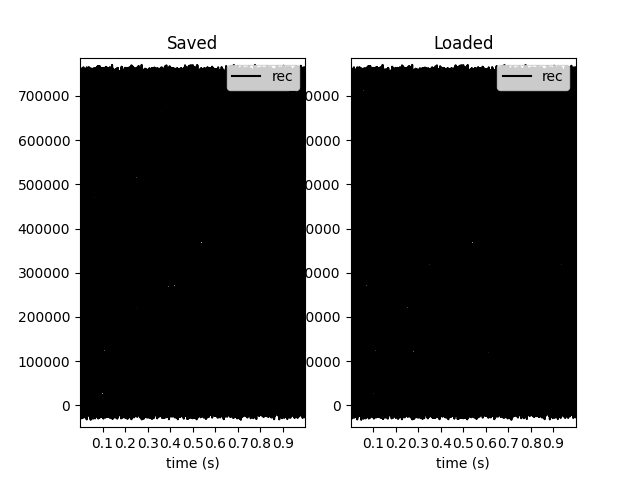

In [62]:
fig, axs = plt.subplots(ncols=2)
w_saved = sw.plot_timeseries(recording_saved, ax=axs[0])
w_loaded = sw.plot_timeseries(recording_loaded, ax=axs[1])
axs[0].set_title("Saved")
axs[1].set_title("Loaded")

**IMPORTANT**: the same saving mechanisms are available also for all SortingExtractor

# 4. Data compression <a class="anchor" id="compression"></a>

Electrophysiology raw data is large! Especially for HD-probes (e.g. Neuropixels data) the acquisition rate can be as high as ~100 GB/hour. 
Lossless data compression can save up storage space (and storage costs!).

In SpikeInterface, we can use the [Zarr](https://zarr.readthedocs.io/en/stable/) framework to gain access to multiple compression options.

The `numcodecs` package is also part of the `Zarr` framework and it contains the low-level compressors.

In [63]:
import numcodecs

[Z-standard](http://facebook.github.io/zstd/) provides good compression for electrophysiology data. 
We'll also use the [Blosc](https://www.blosc.org/) meta-compressor to "shuffle" the data befor compression an improve compression performance:

In [64]:
zstd_compressor = numcodecs.Blosc(cname="zstd", clevel=5, shuffle=numcodecs.Blosc.BITSHUFFLE)

In [65]:
recording_compressed = recording.save(format="zarr", zarr_path="recording_compressed.zarr",
                                      compressor=zstd_compressor, **job_kwargs)

write_zarr_recording with n_jobs = 4 and chunk_size = 30000


write_zarr_recording:   0%|          | 0/16 [00:00<?, ?it/s]

How much did we compress? The compression performance is usually reported in terms of compression ratio (CR):

$$CR = \frac{n\_bytes\_stored}{n\_bytes}$$

In [66]:
cr = recording_compressed.get_annotation("compression_ratio")

print(f"Z-standard compression achieves a CR of {cr} (file size: {np.round(1 / cr * 100, 3)}%)")

Z-standard compression achieves a CR of 1.122247800972421 (file size: 89.107%)


Not bad! Note that compression is a fine art and there are many other compressors and strategies that can boost it. It also strongly depends on the input data.

# 5. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use different spike sorters for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the installed sorters in `SpikeInterface` to see if `tridesclous` is available. Then we can then check the `tridesclous` default parameters.
We will sort the bandpass cached filtered recording the `recording_saved` object.

In [67]:
ss.installed_sorters()

RUNNING SHELL SCRIPT: C:\Users\rodri\AppData\Local\Temp\tmp_shellscript_x9hl5y9\script.bat
RUNNING SHELL SCRIPT: C:\Users\rodri\AppData\Local\Temp\tmp_shellscript5vtuqh6_\script.bat
RUNNING SHELL SCRIPT: C:\Users\rodri\AppData\Local\Temp\tmp_shellscripthogannye\script.bat
RUNNING SHELL SCRIPT: C:\Users\rodri\AppData\Local\Temp\tmp_shellscriptyq300dgq\script.bat
RUNNING SHELL SCRIPT: C:\Users\rodri\AppData\Local\Temp\tmp_shellscriptgdd8pgrf\script.bat
RUNNING SHELL SCRIPT: C:\Users\rodri\AppData\Local\Temp\tmp_shellscript7fyjnxi3\script.bat
RUNNING SHELL SCRIPT: C:\Users\rodri\AppData\Local\Temp\tmp_shellscript3ilsmeh5\script.bat
RUNNING SHELL SCRIPT: C:\Users\rodri\AppData\Local\Temp\tmp_shellscript3e8fygrt\script.bat


['spykingcircus2', 'tridesclous', 'tridesclous2']

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [ ]:
ss.get_default_sorter_params('tridesclous')

In [ ]:
ss.get_sorter_params_description('tridesclous')

In [ ]:
ss.run_sorter?

In [ ]:
ss.run_tridesclous?

To modify a parameter, we can easily pass it to the `run` function as an extra argument!
For example, let's set the `filter` parameter to False as the recording is already preprocessed:

In [ ]:
# run spike sorting on entire recording
sorting_TDC = ss.run_sorter('tridesclous', recording_sub, 
                            output_folder=base_folder / 'results_TDC', 
                            verbose=True)

In [ ]:
sorting_TDC

In [ ]:
print('Found', len(sorting_TDC.get_unit_ids()), 'units')

SpikeInterface ensures full provenance of the spike sorting pipeline. Upon running a spike sorter, a `spikeinterface_params.json` file is saved in the `output_folder`. This contains a `.json` version of the recording and all the input parameters. 

In [ ]:
!ls {base_folder}/results_TDC

In [ ]:
!cat {base_folder}/results_TDC/spikeinterface_params.json

### SpikeInterface-base spike sorters

The `spikeinterface.sortingcomponents` module includes functions that can be used to create custom spike sorting pipelines built-in in `SpikeInterface`. It is still experimental and under heavy development, but there are already two SI-based sorters available:

* `tridesclous2` (developed by Samuel Garcia)
* `spykingcircus2` (developed by Pierre Yger)

They can be run with the same `run_sorter` function, but they don't require any additional installation!

In [ ]:
ss.get_default_sorter_params('tridesclous2')

In [ ]:
sorting_TDC2 = ss.run_sorter('tridesclous2', recording_sub, 
                             output_folder=base_folder/'results_TDC2', 
                             verbose=True)

In [ ]:
sorting_TDC2

### (Optional) Running IronClust (requires MATLAB)

For MATLAB-based sorters, all you need to do is cloning the sorter repo and point it to SpikeInterface:

Let's clone ironclust in the current directory:

In [ ]:
!git clone https://github.com/flatironinstitute/ironclust

Now all we have to tell the IronClustSorter class where is the ironclust repo:

In [ ]:
ss.IronClustSorter.set_ironclust_path('./ironclust')

Note that we can also set a global environment variable called `IRONCLUST_PATH`. In that case we don't need to set the path in each session because the sorter class looks for this environment variable.

Now ironclust should be installed and we can run it:

In [ ]:
ss.IronClustSorter.ironclust_path

In [ ]:
ss.installed_sorters()

In [ ]:
# run spike sorting by group
sorting_IC = ss.run_sorter('ironclust', recording_saved, 
                           output_folder=base_folder/'results_IC',
                           docker_image=True, verbose=True)


In [ ]:
sorting_IC

In [ ]:
print(f'IronClust found {len(sorting_IC.get_unit_ids())} units')

The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

In [ ]:
print(f'IronClust unit ids: {sorting_IC.get_unit_ids()}')

In [ ]:
print(f'Spike train of a unit: {sorting_IC.get_unit_spike_train(1)}')

We can use `spikewidgets` functions for some quick visualizations:

In [ ]:
w_rs = sw.plot_rasters(sorting_IC)

## Running multiple sorter jobs in parallel

So far we have seen how to run one sorter at a time. SI provides a convenient launcher in order to run multiple sorters on multiple recordings with one line of code!

The `run_sorters()` function of the `sorter` module allows you to specify a list of sorters to use on a list (or dictionary) of parameters. The jobs are by default ran in a loop, but the `engine` argument enables to specify a parallel backend (`joblib` or `dask`) and relative parameters.

In the following example, we run the 2 jobs to run `herdingspikes` and `ironclust` in parallel:

In [ ]:
sorting_outputs = ss.run_sorters(sorter_list=["tridesclous", "tridesclous2"],
                                 recording_dict_or_list={"group0": recording_saved},
                                 working_folder=base_folder / "all_sorters1",
                                 verbose=True,
                                 engine="joblib",
                                 engine_kwargs={'n_jobs': 1})

The returned `sorting_outputs` variable is a dictionary that has (rec_name, sorter_name) as keys, and the `SortingExtractor` objects as valus:

In [ ]:
print(sorting_outputs.keys())

For the rest of the tutorial, let's pick the `tridesclous` output:

In [ ]:
sorting = sorting_outputs[('group0', 'tridesclous2')]
sorting

## Spike sort in Docker containers


Some sorters are hard to install! To alleviate this headache, SI provides a built-in mechanism to run a spike sorting job in a docker container.

We are maintaining a set of sorter-specific docker files in the [spikeinterface-dockerfiles repo](<https://github.com/SpikeInterface/spikeinterface-dockerfiles>)
and most of the docker images are available on Docker Hub from the [SpikeInterface organization](<https://hub.docker.com/orgs/spikeinterface/repositories>).

Running spike sorting in a docker container just requires to:

1. have docker installed
2. have docker python SDK installed (`pip install docker`)

When docker is installed, you can simply run the sorter in a specified docker image:

In [ ]:
sorting_SC = ss.run_sorter("spykingcircus", recording_saved, 
                           output_folder=base_folder / "results_SC_docker",
                           docker_image=True, 
                           verbose=True)

In [ ]:
sorting_SC

We can also run MATLAB-based sorters without the need of a MATLAB license!

Let's try with IronClust:

In [ ]:
sorting_IC = ss.run_sorter("ironclust", recording_saved, 
                           output_folder=base_folder / "results_IC_docker",
                           docker_image=True, 
                           verbose=True)

In [ ]:
sorting_IC

In [ ]:
sorting = sorting_TDC

# 6. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core of postprocessing spike sorting results revolves around extracting waveforms from paired recording-sorting objects.

In the SI API, waveforms are extracted using the `WaveformExtractor` class in the `core` module.

The `WaveformExtractor` object has convenient functions to retrieve waveforms and templates.
Let's see how it works.

To extract the waveforms, we can run:

In [ ]:
recording_sub = si.load_extractor(base_folder / "preprocessed")
sorting = se.read_tridesclous(base_folder / "results_TDC")

In [ ]:
si.extract_waveforms?

In [ ]:
we = si.extract_waveforms(recording_sub, sorting, folder=base_folder / "waveforms", 
                          load_if_exists=True, **job_kwargs)
print(we)

Now all waveforms are computed and stored in the provided `wf_IC` folder. We can now retrieve waveforms and templates easily:

In [ ]:
waveforms0 = we.get_waveforms(unit_id=0)
print(f"Waveforms shape: {waveforms0.shape}")
template0 = we.get_template(unit_id=0)
print(f"Template shape: {template0.shape}")
all_templates = we.get_all_templates()
print(f"All templates shape: {all_templates.shape}")

For waveforms, the dimension is (num_spikes, num_samples, num_channels), while each template has dimension (num_samples, num_channels). Note that the number of spikes in this case is 500..we'll get back to it later!

The `WaveformExtractor` is also compatible with several `widgets` to visualize the spike sorting output:

In [ ]:
w = sw.plot_unit_waveforms(we, unit_ids=[2, 3, 4])
w = sw.plot_unit_templates(we, unit_ids=[2, 3, 4])
w = sw.plot_unit_probe_map(we, unit_ids=[2,])

In [ ]:
w = sw.plot_unit_summary(we, unit_id=3)

**NEW in v0.95**: we can also render interactive plots with the `ipywidgets` backend!

In [ ]:
w = sw.plot_unit_templates(we, radius_um=100, backend="ipywidgets")

As we noticed before, the number of spikes for the waveforms is 500. Let's check the number of spikes for other waveforms:

In [ ]:
for unit in sorting.get_unit_ids():
    waveforms = we.get_waveforms(unit_id=unit)
    spiketrain = sorting.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

No units have more than 500 spikes! This is because by default, the `WaveformExtractor` extracts waveforms on a random subset of 500 spikes. To extract waveforms on all spikes, we can use the `max_spikes_per_unit` argument:

In [ ]:
we_all = si.extract_waveforms(recording_sub, sorting, folder=base_folder / "wf_TDC_all", 
                              max_spikes_per_unit=None, progress_bar=True, load_if_exists=True,
                              **job_kwargs)

In [ ]:
for unit in sorting.get_unit_ids():
    waveforms = we_all.get_waveforms(unit_id=unit)
    spiketrain = sorting.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Now waveforms have been extracted for all spikes! Let's move on to explore the postprocessing capabilities of the `postprocessing` module.

# 7. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `postprocessing` module.

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [ ]:
st.compute_principal_components?

In [ ]:
pc = spost.compute_principal_components(we, n_components=3, load_if_exists=True)

In [ ]:
pc0 = pc.get_projections(unit_id=0)
print(f"PC scores shape: {pc0.shape}")
all_labels, all_pcs = pc.get_all_projections()
print(f"All PC scores shape: {all_pcs.shape}")

For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 

## WaveformExtensions

When we compute PCA (or use other postprocessing functions), the computed information is added to the waveform folder. The functions act as `WaveformExtensions`:

In [ ]:
we.get_available_extension_names()

Each `WaveformExtension` is an object that allows us to retrieve the data:

In [ ]:
pc = we.load_extension("principal_components")
print(pc)

In [ ]:
all_labels, all_pcs = pc.get_data()
print(all_pcs.shape)

### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [ ]:
amplitudes = spost.compute_spike_amplitudes(we, outputs="by_unit", load_if_exists=True, 
                                            **job_kwargs)

By default, all amplitudes are concatenated in one array with all amplitudes form all spikes. With the `output="by_unit"` argument, instead, a dictionary is returned:

In [ ]:
amplitudes[0]

In [ ]:
sw.plot_amplitudes_distribution(we)

In [ ]:
sw.plot_amplitudes(we, backend="ipywidgets")

### Compute unit and spike locations

When using silicon probes, we can estimate the unit (or spike) location with triangulation. This can be done either with a simple center of mass or by assuming a monopolar model:

$$V_{ext}(\boldsymbol{r_{ext}}) = \frac{I_n}{4 \pi \sigma |\boldsymbol{r_{ext}} - \boldsymbol{r_{n}}|}$$

where $\boldsymbol{r_{n}}$ is the position of the neuron, and $\boldsymbol{r_{n}}$ of the electrode(s).

In [ ]:
unit_locations = spost.compute_unit_locations(we, method="monopolar_triangulation", load_if_exists=True)
spike_locations = spost.compute_spike_locations(we, method="monopolar_triangulation", load_if_exists=True,
                                                **job_kwargs)

In [ ]:
sw.plot_unit_locations(we, backend="ipywidgets")

In [ ]:
sw.plot_spike_locations(we, backend="ipywidgets")

### Compute correlograms

In [ ]:
ccgs, bins = spost.compute_correlograms(we)

In [ ]:
sw.plot_autocorrelograms(we, unit_ids=sorting.unit_ids[:3])
sw.plot_crosscorrelograms(we, unit_ids=sorting.unit_ids[:3])

### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` allows one to compute several of these metrics:

In [ ]:
print(spost.get_template_metric_names())

In [ ]:
template_metrics = spost.calculate_template_metrics(we)
display(template_metrics)

In [ ]:
sw.plot_template_metrics(we, include_metrics=["peak_to_valley", "half_width"], 
                         backend="ipywidgets")

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

## Sparsity

Especially when working with silicon high-density probes, or when our probe has multiple groups (e.g. multi-shank, tetrodes), we don't care about waveform/templates on all channels. In order to find a subset of channels for each unit, we can use the `get_template_channel_sparsity()`

In [ ]:
spost.get_template_channel_sparsity?

In [ ]:
# example: radius
sparsity_radius = spost.get_template_channel_sparsity(we, method="radius", radius_um=50)
print(sparsity_radius)

In [ ]:
# example: best
sparsity_best = spost.get_template_channel_sparsity(we, method="best_channels", num_channels=4)
print(sparsity_best)

Most of the plotting and exporting functions accept `sparsity` as an argument. 

In [ ]:
sw.plot_unit_templates(we, sparsity=sparsity_radius, backend="ipywidgets")

In [ ]:
sw.plot_unit_templates(we, sparsity=sparsity_best, backend="ipywidgets")

# 8. Quality metrics and curation <a class="anchor" id="curation"></a>

The `qualitymetrics` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

Let's see what metrics are available:

In [ ]:
print(sqm.get_quality_metric_list())

In [ ]:
qm = sqm.compute_quality_metrics(we)

In [ ]:
display(qm)

In [ ]:
sw.plot_quality_metrics(we, include_metrics=["amplitude_cutoff", "presence_ratio", "isi_violations_ratio", "snr"], 
                        backend="ipywidgets")

For more information about these waveform features, we refer to the [SpikeInterface documentation](https://spikeinterface.readthedocs.io/en/latest/module_qualitymetrics.html) and to this excellent [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qm` dataframe based on some thresholds.

Here, we'll only keep units with an ISI violation threshold < 0.2 and amplitude cutoff < 0.9:

In [ ]:
isi_viol_thresh = 0.2
amp_cutoff_thresh = 0.9

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [ ]:
our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_rate < {isi_viol_thresh}"
print(our_query)

and then we can use the query to select units:

In [ ]:
keep_units = qm.query(our_query)
keep_unit_ids = keep_units.index.values

In [ ]:
sorting_auto = sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto.get_unit_ids())}")

# 9. Viewers <a class="anchor" id="viewers"></a>

Let's check put the `spikeinterface-gui` to explore our spike sorting results:

### SpikeInterface GUI

In [ ]:
!sigui waveforms/

### Sorting Summary - SortingView

The `sortingview` backend requires an additional step to configure the transfer of the data to be plotted to the cloud. 

See documentation [here](https://spikeinterface.readthedocs.io/en/latest/module_widgets.html): 

In [ ]:
sw.plot_sorting_summary(we, sparsity=sparsity_radius, 
                        backend="sortingview")

# 10. Spike sorting comparison <a class="anchor" id="comparison"></a>

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `SortingExtractor` with only the units in agreement.

### Compare two sorters

In [ ]:
comp_TDC_IC = sc.compare_two_sorters(sorting_TDC, sorting_IC, 'TDC', 'IC')

In [ ]:
sw.plot_agreement_matrix(comp_TDC_IC)

In [ ]:
comp_SC_IC = sc.compare_two_sorters(sorting_SC, sorting_IC, 'SC', 'IC')
sw.plot_agreement_matrix(comp_SC_IC)

In [ ]:
comp_SC_TDC = sc.compare_two_sorters(sorting_SC, sorting_TDC, 'SC', 'TDC')
sw.plot_agreement_matrix(comp_SC_TDC)

### Compare multiple sorters

In [ ]:
mcmp = sc.compare_multiple_sorters([sorting_TDC, sorting_IC, sorting_SC], ['TDC', 'IC', 'SC'], 
                                   spiketrain_mode='union', verbose=True)

In [ ]:
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [ ]:
sw.plot_multicomp_graph(mcmp, draw_labels=True)

In [ ]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

In [ ]:
sw.plot_rasters(agreement_sorting)

# 11. Exporters <a class="anchor" id="exporters"></a>

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [ ]:
sexp.export_to_phy(we, output_folder=base_folder / 'phy_TDC', 
                   **job_kwargs)

There is a problem with the latest version of Phy so we need to set an environment variable to make it work properly:

- Python:
```
import os
os.environ["QTWEBENGINE_CHROMIUM_FLAGS"] = "--single-process"
```

- OR terminal:

  - Linux/MacOS:
`export QTWEBENGINE_CHROMIUM_FLAGS="--single-process"`

  - Windows:
`set QTWEBENGINE_CHROMIUM_FLAGS="--single-process"`

Then we can run the Phy GUI:

In [ ]:
import os
os.environ["QTWEBENGINE_CHROMIUM_FLAGS"] = "--single-process"

In [ ]:
%%capture --no-display
!phy template-gui phy_TDC/params.py

After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

In [ ]:
sorting_phy_curated = se.PhySortingExtractor(base_folder / 'phy_TDC/', exclude_cluster_groups=['noise'])

In [ ]:
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_phy_curated.get_unit_ids())}")

## Export spike sorting report

In [ ]:
from spikeinterface.exporters import export_report

In [ ]:
%%capture --no-display
sexp.export_report(waveform_extractor=we, output_folder=base_folder/"SI_report", 
                   format="png", show_figures=False)

In [ ]:
!ls {base_folder}/SI_report

In [ ]:
!ls {base_folder}/SI_report/units/

# 12. (optional) Saving to NWB <a class="anchor" id="nwb"></a>


To export to NWB and visualize NWB, we need a couple of additional packages (not installed by default):

- [neuroconv](https://github.com/catalystneuro/neuroconv): NWB conversion of SI objects
- [nwbwidgets](https://github.com/NeurodataWithoutBorders/nwbwidgets): visualization of NWB files in jupyter


In [ ]:
from neuroconv.tools.spikeinterface import write_recording, write_sorting
from datetime import datetime
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget

In [ ]:
metadata = {"NWBFile": {"session_start_time": datetime.now()}}

In [ ]:
_ = write_recording(recording_sub, nwbfile_path="si_tutorial.nwb", metadata=metadata)

In [ ]:
_ = write_sorting(sorting, nwbfile_path="si_tutorial.nwb")

In [ ]:
io = NWBHDF5IO("si_tutorial.nwb", "r")
nwbfile = io.read()

In [ ]:
nwb2widget(nwbfile)

# Bedankt!